## 3 - Количественный модуль

### 3.1 - Библиотеки

In [1]:
import pandas as pd
import numpy as np
import math as math

import yaml
import io

import statsmodels.api as sm
import statsmodels.formula.api as smf

# from _utils.model_test_functions import *
from _utils.monotone_class import *
from _utils.binner_class import *
import _utils.feature_selection_tests as fst
import _utils.woe_analysis as wa 
from itertools import product

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report,
                             roc_auc_score,
                             precision_recall_curve)

from _utils.ExcelExporter import ExcelExporter
from _utils.Style import Style

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.float_format', '{:.6f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # Show full column width
pd.set_option('display.width', None)         # No width limit

### 3.2 - Функции

In [3]:
def model_creation(x: pd.DataFrame,
                   y: pd.Series,
                   sample: pd.Series):

    model = LogisticRegression(penalty='l2', 
                               solver='liblinear', 
                               fit_intercept=True, 
                               random_state=42)

    model.fit(x, y, sample)
    y_pred = model.predict_proba(x)[:, 1]

    coefs,intercept = get_coef(x, y, 5, model, sample)
    model_intercept = intercept

    for i, j in zip(coefs, x.columns):
        intercept += i * x[j]
    
    y_mean = 1 / (1 + np.exp(-intercept))

    return roc_auc_score(y, y_mean) * 2 - 1, roc_auc_score(y, y_pred) * 2 - 1


def get_coef(x: pd.DataFrame,
             y: pd.Series,
             cv: int,
             clf: LogisticRegression,
             sample: pd.Series):
    
    z = x.shape[0] // cv
    x_arr = []
    y_arr = []
    sample_arr = []

    for i in range(cv - 1):
        x_arr.append(pd.concat([x[:i*z], x[(i+1)*z:]], ignore_index=True))
        y_arr.append(pd.concat([y[:i*z], y[(i+1)*z:]], ignore_index=True))
        sample_arr.append(pd.concat([sample[:i*z], sample[(i+1)*z:]], ignore_index=True))

    x_arr.append(x[:(i+1)*z])
    y_arr.append(y[:(i+1)*z])
    sample_arr.append(sample[:(i+1)*z])

    coefs = []
    intercepts = []
    
    for i in range(len(x_arr)):
        clf.fit(x_arr[i], y_arr[i], sample_weight=sample_arr[i])
        coefs.append(clf.coef_[0])
        intercepts.append(clf.intercept_)

    return sum(coefs) / cv, (sum(intercepts) / cv)[0]



def prefilter_features(data, target, weight_col, ratios_dict, top_n=3):
    """
    Step 1: Prefilter features by category

    """
    filtered_ratios = {}
    
    print(f"🎯 Prefiltering: selecting top {top_n} features per category")
    
    for category, available_features in ratios_dict.items():

        if not available_features:
            print(f"⚠️ No available features in {category}")
            continue
            
        # Evaluate each feature individually
        feature_scores = []
        for feature in available_features:
            try:
                if feature not in data.columns:
                    print(f"⚠️ Feature {feature} not found in data")
                    continue
                    
                X_single = data[[feature]]
                y = data[target]
                sample = data[weight_col]
                
                model = LogisticRegression(penalty='l2', solver='liblinear', 
                                         fit_intercept=True, random_state=42)
                model.fit(X_single, y, sample)
                y_pred = model.predict_proba(X_single)[:, 1]
                gini = roc_auc_score(y, y_pred) * 2 - 1
                
                feature_scores.append((feature, gini))
            except Exception as e:
                print(f"Error evaluating {feature}: {e}")
                continue
        
        if not feature_scores:
            print(f"⚠️ No valid features evaluated in {category}")
            continue
            
        # Sort and take top N
        feature_scores.sort(key=lambda x: x[1], reverse=True)
        best_features = [f[0] for f in feature_scores[:top_n]]
        filtered_ratios[category] = best_features
        
        print(f"  {category}: {len(available_features)} → {len(best_features)} features")
        for feat, score in feature_scores[:top_n]:
            print(f"    {feat}: {score:.4f}")
    
    return filtered_ratios

def generate_feature_combinations(ratios_dict):
    """
    Step 2: Generate all possible feature combinations
    """
    print("🔧 Generating feature combinations...")
    
    # Get categories and their features
    categories = list(ratios_dict.keys())
    feature_lists = list(ratios_dict.values())
    
    print(f"Categories: {categories}")
    for cat, features in ratios_dict.items():
        print(f"  {cat}: {len(features)} features - {features}")
    
    # Check if any category is empty
    empty_categories = [cat for cat, features in ratios_dict.items() if not features]
    if empty_categories:
        print(f"⚠️ Empty categories: {empty_categories}")
        # Remove empty categories
        ratios_dict = {k: v for k, v in ratios_dict.items() if v}
        feature_lists = [v for v in feature_lists if v]
        categories = [k for k, v in ratios_dict.items() if v]
    
    if not feature_lists:
        print("❌ No valid features to generate combinations")
        return []
    
    # Calculate total combinations
    total_combinations = 1
    for features in feature_lists:
        total_combinations *= len(features)
    
    print(f"📊 Total possible combinations: {total_combinations:,}")
    
    # Generate all combinations
    combinations = []
    combination_count = 0
    
    for combo in product(*feature_lists):
        # Remove duplicates while preserving order
        unique_combo = list(dict.fromkeys(combo))
        
        if len(unique_combo) >= 2:  # Ensure we have at least 2 features
            combinations.append(unique_combo)
            combination_count += 1
    
    print(f"✅ Generated {len(combinations):,} valid combinations")
    return combinations

def execute_brute_force(combinations, data, target, weight_col, model_creation_func):
    """
    Step 3: Execute brute force evaluation on generated combinations
    """
    print(f"🚀 Executing brute force on {len(combinations):,} combinations...")
    
    results_list = []
    
    for i, combination in enumerate(combinations):
        try:
            # Check if all features exist in data
            missing_features = [f for f in combination if f not in data.columns]
            if missing_features:
                print(f"⚠️ Skipping combination {i+1}: missing features {missing_features}")
                continue
                
            result_dict = {
                'combination_id': i + 1,
                'Columns': '~'.join(combination),
                'num_features': len(combination),
                'features': combination
            }
            
            # Call model creation function
            model_res = model_creation_func(x=data[combination],
                                            y=data[target],
                                            sample=data[weight_col])
            
            result_dict['y_mean_gini'] = model_res[0]
            result_dict['y_pred_gini'] = model_res[1]
            
            results_list.append(result_dict)
            
            # Progress update
            if (i + 1) % 1000 == 0 or i == 0:
                print(f"  Processed {i + 1:,}/{len(combinations):,} combinations...")
                
        except Exception as e:
            print(f"Error in combination {i + 1}: {e}")
            continue
    
    print(f"✅ Successfully processed {len(results_list):,} combinations")
    
    return pd.DataFrame(results_list).sort_values(by=['y_mean_gini', 'y_pred_gini'], ascending=False)

### 3.4 - Пути

In [4]:
with open('../CONFIGS.yaml', 'r', encoding='utf-8') as file:
    CONFIG = yaml.safe_load(file)

PATHS = CONFIG['data_paths']

In [5]:
filepath = {
      'quantitative_module' : PATHS['module_quantitative']['processed_data']
    , 'business_meaning' : PATHS['module_quantitative']['business_meaning']
    , 'rating_weights'      : PATHS['ratings']['weights']
    , 'youngs_data'         : PATHS['case_youngs']['processed_data']

    , 'predictions'      : PATHS['module_quantitative']['predictions']
    , 'woe_category_map' : PATHS['module_quantitative']['woe_category_map']
    , 'config' : PATHS['other']['this_config']
    , 'excel': PATHS['module_quantitative']['excel']
}

### 3.5 - Данные

#### 3.5.1 - Используемые количественные факторы

In [6]:
# old_quantitative_cols = [
#       'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15'
#     , 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26'
#     , 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16'
#     , 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15'
#     , 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26']

#### 3.5.2 - Пояснение бизнес-смысла и корректной монотонности

In [7]:
with open(filepath['business_meaning'], 'r', encoding='utf-8') as file:
    business_meaning = yaml.safe_load(file)

business_meaning_df = pd.DataFrame.from_dict(business_meaning, orient='index')
business_meaning_df = business_meaning_df.reset_index().rename(columns={'index': 'feature'})

negative_corr_business_logic =  business_meaning_df.query('business_logic == "negative"')['feature'].tolist()

#### 3.5.3 - Загрузка датафреймов

In [8]:
df_main   = pd.read_parquet(filepath['quantitative_module'])
df_weight = pd.read_parquet(filepath['rating_weights'])
df_youngs = pd.read_parquet(filepath['youngs_data'])
df = pd.read_parquet(filepath['rating_weights'])

In [9]:
target_col = 'target'
weight_col = 'W_norm'

id_columns = ['rating_id', 'client_id', 'rating_assignment_date', target_col, weight_col]

In [10]:
df = df[id_columns]

In [11]:
df_q = pd.merge(df_main,
                df_youngs,
                how='inner',
                on=['client_id', 'rating_id'])

df_q = pd.merge(df,
                df_q,
                how='inner',
                on=['client_id', 'rating_id'])

### 3.6 - Корректировка расчета выручки

#### Формула для расчета промежуточного параметра (выручка):

**Для обычных компаний:**
$$k_{rev} = k_{rev_{q1}} + k_{rev_{y}} - k_{rev_{q2}}$$

**Для молодых компаний:**
$$k_{rev} = (k_{rev_{q1}} + k_{rev_y}) \times \frac{4}{k_{statements\space count}}$$

, где:
- $k_{statement\space count}$ — количество кварталов "Дата 1" + "Дата 2"

**Условие определения молодой компании:**
$$\text{Молодая компания} = \begin{cases} 
\text{Да}, & \text{если } k_{statement\_count} < 5 \\
\text{Нет}, & \text{если } k_{statement\_count} \geq 5
\end{cases}$$

In [12]:
df_q['k_rev']   = df_q['a1'] + df_q['c1'] - df_q['b1']
df_q['k_rev_2'] = np.where(df_q['f5'] < 5, (df_q['a1'] + df_q['c1']) * (4 / df_q['f5']), df_q['k_rev'])

### 3.7 - Генерация новый переменных

In [13]:
# Коэфициент текущей ликвидности, чем больше тем лучше
df_q.loc[df_q.a21 > 0.01, 'current_ration'] = df_q.a16 / df_q.a21
df_q.loc[df_q.a21 <= 0.01, 'current_ration'] = df_q.a16 / 0.01

# Коэфициент денежной ликвидности, чем больше тем лучше
df_q.loc[df_q.a21 > 0.01, 'cash_ratio'] = df_q.a12 / df_q.a21
df_q.loc[df_q.a21 <= 0.01, 'cash_ratio'] = df_q.a12 / 0.01

# Коэфициент операционной ликвидности, чем больше тем лучше
df_q.loc[df_q.a21 > 0.01, 'operating_cash_flow'] = df_q.a11 / df_q.a21
df_q.loc[df_q.a21 <= 0.01, 'operating_cash_flow'] = df_q.a11 / 0.01

# Коэфициент быстрой ликвидности, чем больше тем лучше
df_q.loc[df_q.a21 > 0.01, 'quick_ratio'] = (df_q.a16 - df_q.a15) / df_q.a21
df_q.loc[df_q.a21 <= 0.01, 'quick_ratio'] = (df_q.a16 - df_q.a15) / 0.01

# Коэфициент задолжности к активам, чем меньше тем лучше
df_q.loc[df_q.a18 > 0.01, 'debt_ratio'] = (df_q.a21 + df_q.a23) / df_q.a18
df_q.loc[df_q.a18 <= 0.01, 'debt_ratio'] = (df_q.a21 + df_q.a23) / 0.01

# Коэфициент задолжности к собственному капиталу, чем меньше тем лучше
df_q.loc[df_q.a25 > 0.01, 'debt_to_equite_ratio'] = (df_q.a21 + df_q.a23) / df_q.a25
df_q.loc[df_q.a25 <= 0.01, 'debt_to_equite_ratio'] = (df_q.a21 + df_q.a23) / 0.01

# Коэфициент обслуживания процентов, чем больше тем лучше
df_q.loc[df_q.a6 > 0.01, 'interest_coverage_ratio'] = df_q.a4 / df_q.a6
df_q.loc[df_q.a6 <= 0.01, 'interest_coverage_ratio'] = df_q.a4 / 0.01

# Коэфициент оборачиваемости активов, чем больше тем лучше
df_q.loc[(df_q.a18 + df_q.b13) > 0.01, 'asset_turnover_ratio'] = df_q.k_rev_2 / ((df_q.a18 + df_q.b14) / 2)
df_q.loc[(df_q.a18 + df_q.b13) <= 0.01, 'asset_turnover_ratio'] = df_q.k_rev_2 / (0.01 / 2)

# Коэфициент затрат на продажи к запасам, чем больше тем лучше
df_q.loc[((df_q.a15 + df_q.b12) > 0.01) & (df_q.a2 > 0.01), 'inventory_turnover'] = df_q.a2 / ((df_q.a15 + df_q.b12) / 2)
df_q.loc[((df_q.a15 + df_q.b12) <= 0.01) & (df_q.a2 > 0.01), 'inventory_turnover'] = df_q.a2 / (0.01 / 2)

# Коэфициент выручки от продаж к дебиторской задолжности, чем больше тем лучше
df_q.loc[(df_q.a14 + df_q.b11) > 0.01, 'recievables_turnover'] = df_q.a1 / ((df_q.a14 + df_q.b11) / 2)
df_q.loc[(df_q.a14 + df_q.b11) <= 0.01, 'recievables_turnover'] = df_q.a1 / (0.01 / 2)

# Коэфициент дней запасов, чем меньше тем лучше
df_q.loc[((df_q.a15 + df_q.b12) > 0.01) & (df_q.a2 > 0.01), 'days_earn_in_inventory'] = 365 / (df_q.a2 / ((df_q.a15 + df_q.b12) / 2))
df_q.loc[((df_q.a15 + df_q.b12) <= 0.01) & (df_q.a2 > 0.01), 'days_earn_in_inventory'] = 365 / (df_q.a2 / (0.01 / 2))

# Коэфициент валовой прибыли, чем больше тем лучше
df_q.loc[df_q.a1 > 0.01, 'gross_profit_margin'] = df_q.a3 / df_q.a1
df_q.loc[df_q.a1 <= 0.01, 'gross_profit_margin'] = df_q.a3 / 0.01

# Коэфициент операционной прибыли, чем больше тем лучше
df_q.loc[df_q.a1 > 0.01, 'operating_profit_margin'] = df_q.a4 / df_q.a1
df_q.loc[df_q.a1 <= 0.01, 'operating_profit_margin'] = df_q.a4 / 0.01

# Эффективность использования активов, чем больше тем лучше
df_q.loc[df_q.a18 > 0.01, 'return_on_assets'] = df_q.a9 / df_q.a18
df_q.loc[df_q.a18 <= 0.01, 'return_on_assets'] = df_q.a9 / 0.01

# Эффективность использования собственных активов, чем больше тем лучше
df_q.loc[df_q.a25 > 0.01, 'return_on_equity'] = df_q.a9 / df_q.a25
df_q.loc[df_q.a25 <= 0.01, 'return_on_equity'] = df_q.a9 / 0.01

# Коэфициент наличия стредств, чем больше тем лучше
df_q.loc[df_q.a1 > 0.01, 'cash_to_earn'] = df_q.a12 / df_q.a1
df_q.loc[df_q.a1 <= 0.01, 'cash_to_earn'] = df_q.a12 / 0.01

# Эффективность компании в производстве или продаже, чем больше тем лушче
df_q.loc[df_q.a1 > 0.01, 'cost_to_earn'] = df_q.a2 / df_q.a1
df_q.loc[df_q.a1 <= 0.01, 'cost_to_earn'] = df_q.a2 / 0.01

# Темп роста выручки, чем больше тем лучше
df_q.loc[df_q.b1 > 0.01, 'earn_growth'] = df_q.a1 / df_q.b1
df_q.loc[df_q.b1 <= 0.01, 'earn_growth'] = df_q.a1 / 0.01

# Коэфициент задолжности по отношению к активам, чем меньше тем лучше
df_q.loc[df_q.a18 > 0.01, 'financial_stability'] = (df_q.a25 + df_q.a24 + df_q.a22) / df_q.a18
df_q.loc[df_q.a18 <= 0.01, 'financial_stability'] = (df_q.a25 + df_q.a24 + df_q.a22) / 0.01

# Рентабельность продаж, чем выше тем лучше
df_q.loc[df_q.a1 > 0.01, 'rate_of_return'] = df_q.a9 / df_q.a1
df_q.loc[df_q.a1 <= 0.01, 'rate_of_return'] = df_q.a9 / 0.01

# Выручка, чем больше тем лучше
df_q.loc[df_q.a1 > 0.01, 'earn'] = df_q.a1
df_q.loc[df_q.a1 <= 0.01, 'earn'] = 0.01

# Коэфициент отношения кредиторской задолжности к активам, чем меньше тем лучше
df_q.loc[df_q.a18 > 0.01, 'pay_to_assets'] = df_q.a20 / df_q.a18
df_q.loc[df_q.a18 <= 0.01, 'pay_to_assets'] = df_q.a20 / 0.01

# Чистая прибыль, чем больше тем лучше
df_q.loc[df_q.a9 > 0.01 ,'net_profit'] = df_q.a9
df_q.loc[df_q.a9 <= 0.01 ,'net_profit'] = 0.01

# Коэфициент отношения кредиторской задолжности к дебиторской задолжности, неоднозначный признак, чем больше тем больше компания имеет гибкость
df_q.loc[df_q.a14 > 0.01 , 'pay_to_receive'] = df_q.a20 / df_q.a14
df_q.loc[df_q.a14 <= 0.01 , 'pay_to_receive'] = df_q.a20 / 0.01

# Коэфициент оборачиваемости оборотного капитала к общей задолжности, чем больше тем лучше
df_q.loc[(df_q.a19 + df_q.a22) > 0.01, 'net_working_capital_to_total_debt'] = (df_q.a16 - df_q.a21) / (df_q.a19 + df_q.a22)
df_q.loc[(df_q.a19 + df_q.a22) <= 0.01, 'net_working_capital_to_total_debt'] = (df_q.a16 - df_q.a21) / 0.01

# Коэфициент покрытия краткосрочных обязательств оборотным капиталом, чем больше тем лучше
df_q.loc[df_q.a19 > 0.01, 'net_working_capital_to__short_tearm_debt'] = (df_q.a16 - df_q.a21) / df_q.a19
df_q.loc[df_q.a19 <= 0.01, 'net_working_capital_to__short_tearm_debt'] = (df_q.a16 - df_q.a21) / 0.01

# Коэфициент отношения долгосрочной задолжности к оборотному капиталу, чем больше тем хуже
df_q.loc[df_q.a22 > 0.01, 'net_working_capital_to__long_tearm_debt'] = (df_q.a16 - df_q.a21) / df_q.a22
df_q.loc[df_q.a22 <= 0.01, 'net_working_capital_to__long_tearm_debt'] = (df_q.a16 - df_q.a21) / 0.01

# Коэфициент соотношения долга к собственному капиталу, чем меньше тем лучше
df_q.loc[(df_q.a19 + df_q.a22 + df_q.a24 + df_q.a25) > 0.01, 'long_term_debt_coefficient'] = (df_q.a19 + df_q.a22) / (df_q.a19 + df_q.a22 + df_q.a24 + df_q.a25)
df_q.loc[(df_q.a19 + df_q.a22 + df_q.a24 + df_q.a25) <= 0.01, 'long_term_debt_coefficient'] = (df_q.a19 + df_q.a22) / 0.01

# Коэфициент отношения дебиторской задолжности к краткосрочной задолжности, чем больше тем лучше
df_q.loc[df_q.a19 > 0.01, 'recievables_to_short_tearm_debt'] = df_q.a14 / df_q.a19
df_q.loc[df_q.a19 <= 0.01, 'recievables_to_short_tearm_debt'] = df_q.a14 / 0.01

# Коэфициент отношения денежных средств и эквивалентов к краткосрочной задолжности, чем больше тем лучше
df_q.loc[df_q.a19 > 0.01, 'short_tearm_liquidity'] = df_q.a12 / df_q.a19
df_q.loc[df_q.a19 <= 0.01, 'short_tearm_liquidity'] = df_q.a12 / 0.01

# Коэфициент чистого оборотного капитала к активам, чем больше тем лучше
df_q.loc[df_q.a18 > 0.01, 'net_working_capital_to__assets'] = (df_q.a16 - df_q.a21) / df_q.a18
df_q.loc[df_q.a18 <= 0.01, 'net_working_capital_to__assets'] = (df_q.a16 - df_q.a21) / 0.01

# Прибыльность, чем больше тем лучше
df_q.loc[(df_q.a1 > 0.01) & (df_q.b1 > 0.01), 'profitability_dynamics'] = (df_q.a9 / df_q.a1) - (df_q.b9 / df_q.b1)
df_q.loc[(df_q.a1 > 0.01) & (df_q.b1<=0.01), 'profitability_dynamics'] = (df_q.a9 / df_q.a1) - (df_q.b9 / 0.01)
df_q.loc[(df_q.a1 <= 0.01) & (df_q.b1 <= 0.01), 'profitability_dynamics'] = (df_q.a9 / 0.01) - (df_q.b9 / 0.01)
df_q.loc[(df_q.a1 <= 0.01) & (df_q.b1 > 0.01), 'profitability_dynamics'] = (df_q.a9 / 0.01) - (df_q.b9 / df_q.b1)
#df_q.loc[df_q.b9.isna()==True,'profitability_dynamics']=1

# Чистый оборотный капитал, чем больше тем лучше
df_q['net_working_capital'] = df_q.a16 - df_q.a21

# Долговая нагрузка, чем меньше тем лучше
df_q.loc[df_q.a11 > 0.01, 'total_debt_to_cfo'] = (df_q.a19 + df_q.a22) / df_q.a11
df_q.loc[df_q.a11 < 0.01, 'total_debt_to_cfo'] = (df_q.a19 + df_q.a22) / 0.01

# Маржа денежного потока, чем больше тем лучше
df_q.loc[df_q.a9 > 0.01, 'cfo_to_net_income'] = df_q.a11 / df_q.a9
df_q.loc[df_q.a9 <= 0.01, 'cfo_to_net_income'] = df_q.a11 / 0.01

# Показатель эффективности компании в использовании ресурсов, чем больше тем лучше
df_q.loc[(df_q.a25 + df_q.a23) > 0.01, 'return_on_investments'] = df_q.a9 / (df_q.a25 + df_q.a23)
df_q.loc[(df_q.a25 + df_q.a23) <= 0.01, 'return_on_investments'] = df_q.a9 / 0.01

# Рентабильность активов, чем больше тем лучше
df_q.loc[(df_q.a16 + df_q.b13) > 0.01, 'return_on_curent_assets'] = df_q.a9 / ((df_q.a16 + df_q.b13) / 2)
df_q.loc[(df_q.a16 + df_q.b13) <= 0.01, 'return_on_curent_assets'] = df_q.a9 / (0.01 / 2)

# Так же Коэфициент текущей ликвидности, выше 1 хорошо, ниже плохо
df_q.loc[df_q.a18 > 0.01, 'current_liabilty_to_assets'] = df_q.a21 / df_q.a18
df_q.loc[df_q.a18 <= 0.01, 'current_liabilty_to_assets'] = df_q.a21 / 0.01

# Коэфициент финансового плеча, чем меньше тем лучше
df_q.loc[df_q.a25 > 0.01, 'financing_ratio'] = (df_q.a22 + df_q.a19) / df_q.a25
df_q.loc[df_q.a25 <= 0.01, 'financing_ratio'] = (df_q.a22 + df_q.a19) / 0.01

# Коэфициент собственного капитала, чем больше тем лучше
df_q.loc[df_q.a18 > 0.01, 'autonomous_ration'] = df_q.a25 / df_q.a18
df_q.loc[df_q.a18 <= 0.01, 'autonomous_ration'] = df_q.a25 / 0.01

# Относительный рост выручки, чем больше тем лучше
df_q.loc[df_q.b1 == 0, 'revenue'] = -1
df_q.loc[df_q.b1 != 0, 'revenue'] = df_q.a1 / df_q.b1

# Коэфициент обеспеченности денежными средствами, чем больше тем лучше
df_q.loc[(df_q.a21 + df_q.a23) > 0.01, 'liab_coverage'] = df_q.a11 / (df_q.a21 + df_q.a23)
df_q.loc[(df_q.a21 + df_q.a23) <= 0.01, 'liab_coverage'] = df_q.a11 / 0.01

# Коэфициент покрытия долга денежными потоками, чем больше тем лучше
df_q.loc[(df_q.a19 + df_q.a22) > 0.01, 'debt_coverage'] = df_q.a11 / (df_q.a19 + df_q.a22)
df_q.loc[(df_q.a19 + df_q.a22) <= 0.01, 'debt_coverage'] = df_q.a11 / 0.01

In [14]:
stop = df_q.columns.values.tolist().index('f5')
df_q = df_q[id_columns + df_q.columns[stop+1:].values.tolist()]
df_qq = df_q.copy()
df_qq = df_qq.drop(columns=['k_rev', 'k_rev_2'])

In [15]:
df_qq.head()

,rating_id,client_id,rating_assignment_date,target,W_norm,current_ration,cash_ratio,operating_cash_flow,quick_ratio,debt_ratio,debt_to_equite_ratio,interest_coverage_ratio,asset_turnover_ratio,inventory_turnover,recievables_turnover,days_earn_in_inventory,gross_profit_margin,operating_profit_margin,return_on_assets,return_on_equity,cash_to_earn,cost_to_earn,earn_growth,financial_stability,rate_of_return,earn,pay_to_assets,net_profit,pay_to_receive,net_working_capital_to_total_debt,net_working_capital_to__short_tearm_debt,net_working_capital_to__long_tearm_debt,long_term_debt_coefficient,recievables_to_short_tearm_debt,short_tearm_liquidity,net_working_capital_to__assets,profitability_dynamics,net_working_capital,total_debt_to_cfo,cfo_to_net_income,return_on_investments,return_on_curent_assets,current_liabilty_to_assets,financing_ratio,autonomous_ration,revenue,liab_coverage,debt_coverage
0,665,3144132,2018-07-02,0,2.268403,1.509362,0.009001,-0.135104,0.397385,0.685007,2.174669,11.357988,7.753963,2.370331,9.324610,153.986963,0.083306,0.036498,0.052583,0.166935,0.003743,0.916694,1.370678,0.657864,0.033281,4022231.000000,0.465636,133862.000000,2.753384,2.101431,2.548113,11.987703,0.201808,1.287505,0.045027,0.334695,0.010058,852038.000000,40545600.000000,-1.688269,0.153343,0.062029,0.657087,0.505630,0.314993,1.370678,-0.129597,-0.557385
1,739,968098,2018-07-02,0,2.896664,0.839505,0.108990,0.036972,0.546053,0.928724,13.030006,3.884911,1.960709,0.988205,10.752507,369.356659,0.254633,0.035958,0.012178,0.170852,0.208714,0.745367,2.069448,0.142505,0.025113,956586.000000,0.070819,24023.000000,2.205582,-0.980010,-0.980010,-29400300.000000,0.516242,0.211140,0.665510,-0.149035,-0.010295,-294003.000000,4.429483,2.819298,0.170538,0.014878,0.928593,2.133606,0.071276,2.069448,0.036967,0.225760
2,802,752428,2018-07-02,0,2.495493,1.012214,0.005802,-0.043681,0.755130,0.886806,7.834384,-445.849593,2.035880,1.640327,1.534156,222.516621,0.003981,-0.271257,-0.096882,-0.855897,0.013198,0.996019,1.278624,0.199621,-0.271865,808672.000000,0.280590,0.010000,0.785496,2247000.000000,2247000.000000,2247000.000000,0.000000,81060500.000000,1067300.000000,0.009902,-0.069614,22470.000000,0.000000,-8036000.000000,-0.511811,-0.126909,0.810707,0.000000,0.113194,1.278624,-0.039933,-8036000.000000
3,755,741036,2018-07-03,0,1.588171,1.217128,0.033704,0.364422,0.635000,0.460988,0.855246,6.958660,0.909484,1.024688,1.252273,356.206150,0.260324,0.158167,0.039744,0.073735,0.044770,0.739676,1.398022,0.859805,0.135438,605556.000000,0.057895,82015.000000,0.360673,0.497939,0.856741,1.188969,0.177317,1.624867,0.132988,0.084637,-0.036073,174656.000000,1.196563,3.574200,0.065133,0.066497,0.389803,0.315346,0.539012,1.398022,0.308149,0.835727
4,795,749958,2018-07-03,0,1.702806,1.000489,0.059750,0.002477,0.384678,0.942302,16.331718,-1.833983,1.854858,0.293907,0.824655,1241.890581,0.227489,-0.047746,-0.016171,-0.280271,0.255267,0.772511,0.983213,0.115265,-0.073316,256355.000000,0.208822,0.010000,0.684476,0.002680,0.002680,53600.000000,0.598856,1.772958,0.327198,0.000461,-0.021792,536.000000,73.718393,271300.000000,-0.280271,-0.018002,0.942302,2.982374,0.057698,0.983213,0.002477,0.013565


### 3.7 - Замена исходных значений на WoE-значения

In [16]:
df_qq = df_qq.dropna(axis=1)

In [17]:
binner = Binner()
bins = binner.fit(np.array(df_qq[weight_col]), df_qq.drop(['rating_id','client_id','rating_assignment_date', weight_col], axis=1), target_col)
df_woe = binner.transform(df_qq)
df_woe[weight_col] = df_qq[weight_col]
df_woe['client_id'] = df_qq['client_id']
df_woe['rating_assignment_date'] = df_qq['rating_assignment_date']
df_woe['rating_id'] = df_qq['rating_id']

In [18]:
quantitative_features = df_woe\
                    .drop([target_col, weight_col, 'client_id', 'rating_assignment_date', 'rating_id'], axis=1)\
                    .columns.to_list()
quantitative_features

['current_ration_woe',
 'cash_ratio_woe',
 'operating_cash_flow_woe',
 'quick_ratio_woe',
 'debt_ratio_woe',
 'debt_to_equite_ratio_woe',
 'interest_coverage_ratio_woe',
 'asset_turnover_ratio_woe',
 'recievables_turnover_woe',
 'gross_profit_margin_woe',
 'operating_profit_margin_woe',
 'return_on_assets_woe',
 'return_on_equity_woe',
 'cash_to_earn_woe',
 'cost_to_earn_woe',
 'earn_growth_woe',
 'financial_stability_woe',
 'rate_of_return_woe',
 'earn_woe',
 'pay_to_assets_woe',
 'net_profit_woe',
 'pay_to_receive_woe',
 'net_working_capital_to_total_debt_woe',
 'net_working_capital_to__short_tearm_debt_woe',
 'net_working_capital_to__long_tearm_debt_woe',
 'long_term_debt_coefficient_woe',
 'recievables_to_short_tearm_debt_woe',
 'short_tearm_liquidity_woe',
 'net_working_capital_to__assets_woe',
 'profitability_dynamics_woe',
 'net_working_capital_woe',
 'total_debt_to_cfo_woe',
 'cfo_to_net_income_woe',
 'return_on_investments_woe',
 'return_on_curent_assets_woe',
 'current_liabil

In [19]:
df_woe = df_woe[id_columns + quantitative_features]

#### 3.7.1 - Сохранение информации о бинах в WOE преобразовании

In [20]:
# 1. Собираем информацию о WoE и границах
binning_info = []

for bin_object, feature_name in zip(bins, quantitative_features):
    woe_values = bin_object._woes
    
    for bin_boundaries, woe_value in zip(bin_object._gaps, woe_values):
        bin_row = {
            'feature_name': feature_name, 
            'woe': woe_value,
            'boundary_0': float(np.round(bin_boundaries[0], 7)),
            'boundary_1': float(np.round(bin_boundaries[1], 7))
        }
        binning_info.append(bin_row)

binning_df = pd.DataFrame(binning_info)
binning_df

,feature_name,woe,boundary_0,boundary_1
0,current_ration_woe,-0.819988,-100000000000000.000000,0.968601
1,current_ration_woe,-0.014998,0.968601,2.060115
2,current_ration_woe,0.760640,2.060115,100000000000000.000000
3,cash_ratio_woe,-0.746159,-100000000000000.000000,0.010074
4,cash_ratio_woe,-0.107488,0.010074,0.090135
...,...,...,...,...
109,revenue_woe,0.166313,0.639260,100000000000000.000000
110,liab_coverage_woe,-0.141428,-100000000000000.000000,0.059216
111,liab_coverage_woe,0.305124,0.059216,100000000000000.000000
112,debt_coverage_woe,-0.102008,-100000000000000.000000,0.650515


In [21]:
# 2. Считаем статистику для каждого WoE
total_weight = df_woe[weight_col].sum()
total_bads = (df_woe[target_col] * df_woe[weight_col]).sum()

stats_list = []
for feature in binning_df['feature_name'].unique():
    # Группируем по WoE значениям (они есть в df_woe)
    g = (df_woe
         .groupby(feature)
         .apply(lambda x: pd.Series({
             'count_obs': x[weight_col].sum(),
             'bads': (x[target_col] * x[weight_col]).sum(),
             'share_of_bad': (x[target_col] * x[weight_col]).sum() / x[weight_col].sum()
         }))
         .reset_index()
         .rename(columns={feature: 'woe'}))
    
    g['feature_name'] = feature
    g['general_distribution'] = g['count_obs'] / total_weight
    g['distribution_of_bad'] = g['bads'] / total_bads
    stats_list.append(g)

woe_stats = pd.concat(stats_list, ignore_index=True)

woe_stats

,woe,count_obs,bads,share_of_bad,feature_name,general_distribution,distribution_of_bad
0,-0.819988,725.770883,80.693372,0.111183,current_ration_woe,0.145620,0.294148
1,-0.014998,2652.346495,152.801257,0.057610,current_ration_woe,0.532172,0.557000
2,0.760640,1605.882622,40.834203,0.025428,current_ration_woe,0.322208,0.148851
3,-0.746159,716.292584,77.061204,0.107583,cash_ratio_woe,0.143718,0.280908
4,-0.107488,1978.924852,120.372601,0.060827,cash_ratio_woe,0.397056,0.438789
...,...,...,...,...,...,...,...
109,0.166313,4426.907822,206.552238,0.046658,revenue_woe,0.888224,0.752937
110,-0.141428,3121.204243,201.193634,0.064460,liab_coverage_woe,0.626245,0.733403
111,0.305124,1862.795757,73.135198,0.039261,liab_coverage_woe,0.373755,0.266597
112,-0.102008,3947.671333,247.923018,0.062802,debt_coverage_woe,0.792069,0.903744


In [22]:
# 3. Объединяем с границами
bins_master = binning_df.merge(woe_stats, on=['feature_name', 'woe'], how='left')

In [23]:
# 4. Проставляем категории согласно бизнес-смыслу
def assign_business_categories(df):
    result = []
    
    for feature in df['feature_name'].unique():
        feature_data = df[df['feature_name'] == feature].copy()
        
        if feature in negative_corr_business_logic:
            # Для negative correlation: меньше значение = лучше
            # Сортируем по boundary_0 по возрастанию
            # Категория 1 = самые низкие значения (лучшие)
            feature_data = feature_data.sort_values('boundary_0', ascending=True)
        else:
            # Для positive correlation: больше значение = лучше  
            # Сортируем по boundary_0 по убыванию
            # Категория 1 = самые высокие значения (лучшие)
            feature_data = feature_data.sort_values('boundary_0', ascending=False)
        
        # Присваиваем категории: 1 = лучшие, K = худшие
        feature_data['category'] = range(1, len(feature_data) + 1)
        result.append(feature_data)
    
    return pd.concat(result, ignore_index=True)

bins_master = assign_business_categories(bins_master)

# Добавляем бизнес-логику
bins_master['business_logic'] = bins_master['feature_name'].apply(
    lambda f: 'negative' if f in negative_corr_business_logic else 'positive'
)
bins_master = bins_master[['feature_name','category', 'business_logic', 'woe', 'boundary_0', 'boundary_1', 
               'share_of_bad', 'distribution_of_bad', 'bads', 'count_obs', 'general_distribution']]

### 3.8 - Статистические тесты

#### 3.8.1 - Проверка на монотонность

In [24]:
# 1. Создаем feature_woe_info из bins_master
feature_woe_info = {}
for feature in bins_master['feature_name'].unique():
    feature_data = bins_master[bins_master['feature_name'] == feature]
    feature_woe_info[feature] = feature_data[['category', 'woe', 'share_of_bad']].copy()


# 2. Ваш код работает как задумано:
feature_monotonicity_info = { 
    col:wa.check_woe_monotonicity(feature_woe_info[col]) 
    for col in quantitative_features 
}

monotonic_features = [ 
    col for col in quantitative_features 
    if feature_monotonicity_info[col]['is_monotonic'] 
    and feature_monotonicity_info[col]['follows_business_logic']
]

In [25]:
non_monotonic_features = set(quantitative_features) - set(monotonic_features)

In [26]:
set(non_monotonic_features) - set(negative_corr_business_logic)

{'cfo_to_net_income_woe',
 'gross_profit_margin_woe',
 'net_working_capital_to_total_debt_woe'}

In [27]:
 set(negative_corr_business_logic) - set(non_monotonic_features) 

{'current_liabilty_to_assets_woe',
 'debt_ratio_woe',
 'debt_to_equite_ratio_woe',
 'financing_ratio_woe',
 'long_term_debt_coefficient_woe',
 'pay_to_receive_woe',
 'total_debt_to_cfo_woe'}

In [28]:
set(non_monotonic_features) - set(negative_corr_business_logic)

{'cfo_to_net_income_woe',
 'gross_profit_margin_woe',
 'net_working_capital_to_total_debt_woe'}

In [29]:
# mono = monotone(1, True, df_woe, target_col, quantitative_features, 1, df_woe)
# mono.fit()
# mono.semaphore()
# mono.graph()

#### 3.8.2 - Корреляционный анализ

In [30]:
id_columns = ['client_id', 'rating_id', target_col, weight_col]

Cramer's V

In [31]:
redundancy = fst.analyze_feature_redundancy(df_woe, quantitative_features, threshold=0.7)
print("n⚠️ Потенциально взаимозаменяемые признаки:")
for main_feat, info in redundancy.items():
    print(f"n  {main_feat}:")
    for corr_feat in info['correlated_with']:
        print(f"    - {corr_feat['feature']} (V={corr_feat['correlation']:.3f})")

n⚠️ Потенциально взаимозаменяемые признаки:
n  debt_ratio_woe:
    - debt_to_equite_ratio_woe (V=1.000)
    - autonomous_ration_woe (V=0.997)
    - financial_stability_woe (V=0.722)
n  debt_to_equite_ratio_woe:
    - debt_ratio_woe (V=1.000)
    - autonomous_ration_woe (V=0.998)
    - financial_stability_woe (V=0.723)
n  autonomous_ration_woe:
    - debt_to_equite_ratio_woe (V=0.998)
    - debt_ratio_woe (V=0.997)
    - financial_stability_woe (V=0.726)
n  return_on_equity_woe:
    - return_on_investments_woe (V=0.958)
    - rate_of_return_woe (V=0.924)
    - return_on_assets_woe (V=0.909)
    - return_on_curent_assets_woe (V=0.905)
    - operating_profit_margin_woe (V=0.773)
    - net_profit_woe (V=0.746)
n  return_on_investments_woe:
    - return_on_equity_woe (V=0.958)
    - rate_of_return_woe (V=0.921)
    - operating_profit_margin_woe (V=0.799)
    - return_on_assets_woe (V=0.768)
n  earn_growth_woe:
    - revenue_woe (V=0.932)
n  revenue_woe:
    - earn_growth_woe (V=0.932)
n  ra

Spearman

In [32]:
spearman_corr = pd.DataFrame(df_woe[quantitative_features].corr(method='spearman').unstack(), 
                             columns=['value'])
spearman_corr = spearman_corr[abs(spearman_corr.value) > 0.65].reset_index()
spearman_corr.columns = ['col1', 'col2', 'value']
spearman_corr = spearman_corr.query('col1 != col2').set_index(['col1']).set_axis(['correlated_with', 'corr_strength'], axis=1)
spearman_corr_info = spearman_corr.T.to_dict()
spearman_corr_info

{'current_ration_woe': {'correlated_with': 'net_working_capital_to__assets_woe',
  'corr_strength': 0.7613205835792884},
 'operating_cash_flow_woe': {'correlated_with': 'liab_coverage_woe',
  'corr_strength': 0.8940587049686797},
 'debt_ratio_woe': {'correlated_with': 'autonomous_ration_woe',
  'corr_strength': 0.9935913119314705},
 'debt_to_equite_ratio_woe': {'correlated_with': 'autonomous_ration_woe',
  'corr_strength': 0.9945004156089717},
 'interest_coverage_ratio_woe': {'correlated_with': 'return_on_assets_woe',
  'corr_strength': 0.6717632719626884},
 'operating_profit_margin_woe': {'correlated_with': 'rate_of_return_woe',
  'corr_strength': 0.7841586679372176},
 'return_on_assets_woe': {'correlated_with': 'return_on_investments_woe',
  'corr_strength': 0.8514137302058951},
 'return_on_equity_woe': {'correlated_with': 'return_on_curent_assets_woe',
  'corr_strength': 0.7021962947619741},
 'earn_growth_woe': {'correlated_with': 'revenue_woe',
  'corr_strength': 0.9329902973426814

#### 3.8.3 - Gini

In [33]:
df_gini_results = fst.calculate_features_gini(df_woe
                                            , target_col
                                            , quantitative_features
                                            , weight_col)\
                    .sort_values(['Gini'], ascending=False)\
                    .drop_duplicates()

feature_gini_info = df_gini_results['Gini'].to_dict()

feature_gini_info

{'autonomous_ration_woe': 0.299147169459252,
 'debt_ratio_woe': 0.29453654109574523,
 'debt_to_equite_ratio_woe': 0.2941769188687169,
 'asset_turnover_ratio_woe': 0.28942634317629556,
 'net_working_capital_to__assets_woe': 0.2683485791105287,
 'current_ration_woe': 0.2675962561969101,
 'net_working_capital_to_total_debt_woe': 0.26278037175099556,
 'net_working_capital_to__short_tearm_debt_woe': 0.2580255552304256,
 'cash_ratio_woe': 0.25453026467008466,
 'financial_stability_woe': 0.2371598325721047,
 'interest_coverage_ratio_woe': 0.22433302375287845,
 'net_working_capital_woe': 0.22066301107280228,
 'financing_ratio_woe': 0.21221188873763275,
 'return_on_assets_woe': 0.20522130761695134,
 'net_working_capital_to__long_tearm_debt_woe': 0.20153772428679861,
 'long_term_debt_coefficient_woe': 0.19801953325445387,
 'earn_woe': 0.1826507720427646,
 'recievables_turnover_woe': 0.18046250471792136,
 'return_on_investments_woe': 0.16941599555561204,
 'net_profit_woe': 0.16708862906748423,
 '

#### 3.8.4 - VIF

In [34]:
feature_vif_info = fst.calculate_vif(df=df_woe,
                    target=target_col,
                    features=quantitative_features)
print(feature_vif_info)

{'current_ration_woe': 6.47068512162448, 'cash_ratio_woe': 2.089299237181971, 'operating_cash_flow_woe': 5.802771477136948, 'quick_ratio_woe': 2.1065593703918353, 'debt_ratio_woe': 486.2899264313322, 'debt_to_equite_ratio_woe': 565.0196017176232, 'interest_coverage_ratio_woe': 2.5064333432446966, 'asset_turnover_ratio_woe': 1.963034952262949, 'recievables_turnover_woe': 1.5118672507898625, 'gross_profit_margin_woe': 1.823373483207728, 'operating_profit_margin_woe': 3.056558479925818, 'return_on_assets_woe': 4.4874019778461065, 'return_on_equity_woe': 8.289504350836893, 'cash_to_earn_woe': 1.5871384894091656, 'cost_to_earn_woe': 1.6029241060183737, 'earn_growth_woe': 8.17282388195176, 'financial_stability_woe': 4.397134566073252, 'rate_of_return_woe': 8.254307668859127, 'earn_woe': 2.0232731144321887, 'pay_to_assets_woe': 1.5371785023191402, 'net_profit_woe': 4.258750961500294, 'pay_to_receive_woe': 1.286116627145709, 'net_working_capital_to_total_debt_woe': 7.968048113343936, 'net_work

#### 3.8.5 - Тест Вальда

In [35]:
feature_wald_test_info = {col : fst.quick_wald_test(df=df_woe, feature=col, target=target_col, weights_col=weight_col) for col in quantitative_features}
feature_wald_test_info

{'current_ration_woe': {'coefficient': np.float64(-1.0031256651206386),
  'std_error': np.float64(0.1253590281611496),
  'wald_statistic': np.float64(64.03235147675332),
  'p_value': np.float64(1.2239279709562469e-15),
  'is_significant': np.True_,
  'weighted': True,
  'effective_sample_size': np.float64(4984.0)},
 'cash_ratio_woe': {'coefficient': np.float64(-1.0010891996198603),
  'std_error': np.float64(0.1343620502941987),
  'wald_statistic': np.float64(55.512694428535475),
  'p_value': np.float64(9.28574224620654e-14),
  'is_significant': np.True_,
  'weighted': True,
  'effective_sample_size': np.float64(4984.0)},
 'operating_cash_flow_woe': {'coefficient': np.float64(-1.015551340258863),
  'std_error': np.float64(0.5461489203235683),
  'wald_statistic': np.float64(3.4576546069096175),
  'p_value': np.float64(0.06295956047160615),
  'is_significant': np.False_,
  'weighted': True,
  'effective_sample_size': np.float64(4984.0)},
 'quick_ratio_woe': {'coefficient': np.float64(-1.0

#### 3.9 - Отбор признаков

In [36]:
# НАСТРОЙКИ:
date_column = 'rating_assignment_date'
baseline_year = '2023'  # ЗАМЕНИТЕ на ваш базовый год
time_period = 'year'  # 'quarter', 'year', или 'month'

# Собираем все результаты в один датафрейм
feature_analysis_results = []

# Параметры фильтрации
vif_upper_bound = 5
cramer_lower_bound = 0.01
cramer_upper_bound = 0.7
gini_lower_bound = 0.05

for feature in quantitative_features:
    feature_info = {
        'feature': feature,
        'is_monotonic': None,
        'cramers_v_target': None,
        'gini': None,
        'vif': None,
        'wald_p_value': None,
        'wald_significant': None,
        'wald_coefficient': None,
        'spearman_corr': None,
        'max_cramers_with_others': 0,
        'highly_correlated_features': [],
        'redundancy_score': 0,
        'psi_static': None,
        'psi_dynamic_mean': None,
        'psi_dynamic_max': None,
        'psi_periods_unstable': 0
    }
    
    # Cramér's V с целевой переменной
    feature_info['cramers_v_target'] = fst.calculate_cramers_v(df_woe[feature], df_woe[target_col], df_woe[weight_col])

    if feature in feature_monotonicity_info:
        feature_info['is_monotonic'] = feature_monotonicity_info[feature]['follows_business_logic']
    
    # Gini
    if feature in feature_gini_info:
        feature_info['gini'] = feature_gini_info[feature]
    
    # VIF
    if feature in feature_vif_info:
        feature_info['vif'] = feature_vif_info[feature]
    
    # Wald тест
    if feature in feature_wald_test_info and feature_wald_test_info[feature] is not None:
        wald_result = feature_wald_test_info[feature]
        feature_info['wald_p_value'] = wald_result['p_value']
        feature_info['wald_significant'] = wald_result['is_significant']
        feature_info['wald_coefficient'] = abs(wald_result['coefficient'])
    
    # Spearman корреляция
    if feature in spearman_corr_info:
        feature_info['spearman_corr'] = spearman_corr_info[feature]['corr_strength']
    
    # Избыточность
    if feature in redundancy:
        corr_features = redundancy[feature]['correlated_with']
        feature_info['max_cramers_with_others'] = redundancy[feature]['max_correlation']
        feature_info['highly_correlated_features'] = [f"{cf['feature']}({cf['correlation']:.3f})" for cf in corr_features]
        feature_info['redundancy_score'] = len(corr_features)
    
    # PSI расчеты с джойненными данными
    try:
        # Static PSI: базовый год vs остальные годы
        baseline_mask = df_woe[date_column].dt.year.astype(str) == baseline_year
        
        if baseline_mask.sum() > 50 and (~baseline_mask).sum() > 50:  # минимум 50 наблюдений
            baseline_woe = df_woe[baseline_mask][feature]
            other_years_woe = df_woe[~baseline_mask][feature]
            feature_info['psi_static'] = fst.calculate_psi_woe(baseline_woe, other_years_woe)
        
        # Dynamic PSI: между соседними периодами
        if time_period == 'quarter':
            df_woe['period'] = df_woe[date_column].dt.to_period('Q')
        elif time_period == 'year':
            df_woe['period'] = df_woe[date_column].dt.to_period('Y')
        else:
            df_woe['period'] = df_woe[date_column].dt.to_period('M')
        
        periods = sorted(df_woe['period'].unique())
        
        if len(periods) > 1:
            period_psi_values = []
            
            for j in range(1, len(periods)):
                prev_period_woe = df_woe[df_woe['period'] == periods[j-1]][feature]
                curr_period_woe = df_woe[df_woe['period'] == periods[j]][feature]
                
                if len(prev_period_woe.dropna()) > 20 and len(curr_period_woe.dropna()) > 20:
                    psi_val = fst.calculate_psi_woe(prev_period_woe, curr_period_woe)
                    if not np.isnan(psi_val):
                        period_psi_values.append(psi_val)
            
            if period_psi_values:
                feature_info['psi_dynamic_mean'] = np.mean(period_psi_values)
                feature_info['psi_dynamic_max'] = np.max(period_psi_values)
                feature_info['psi_periods_unstable'] = sum(1 for psi in period_psi_values if psi > 0.2)
    
    except Exception as e:
        print(f"Ошибка PSI для {feature}: {e}")
    
    feature_analysis_results.append(feature_info)

# Создаем датафрейм
df_feature_analysis = pd.DataFrame(feature_analysis_results)

# Добавляем PSI критерии к маске
psi_static_stable = df_feature_analysis['psi_static'].fillna(0) <= 0.2
psi_dynamic_stable = df_feature_analysis['psi_dynamic_mean'].fillna(0) <= 0.15

# Маска для хороших признаков
good_features_mask = (
      (df_feature_analysis['is_monotonic']) 
    & (df_feature_analysis['gini'].fillna(0) >= gini_lower_bound) 
    # & (df_feature_analysis['vif'].fillna(1) <= vif_upper_bound) 
    # & (df_feature_analysis['cramers_v_target'].fillna(0) >= cramer_lower_bound) 
    # & (df_feature_analysis['max_cramers_with_others'] <= cramer_upper_bound) 
    # & (df_feature_analysis['wald_significant'].fillna(False)) 
    # & psi_static_stable 
    # & psi_dynamic_stable
)


df_feature_analysis = df_feature_analysis.sort_values(by=['gini', 'vif', 'cramers_v_target', 'max_cramers_with_others']
                                                    , ascending=[False, True, False, True])

good_features_df = df_feature_analysis[good_features_mask].sort_values('gini', ascending=False)
best_features = good_features_df['feature'].tolist()

print(f"Хороших признаков: {len(good_features_df)} из {len(df_feature_analysis)}")

print("\nTоп-10 отобранных признаков:")
print(good_features_df[['feature', 'cramers_v_target', 'gini', 'vif', 'psi_static', 'psi_dynamic_mean']].head(10))

print("\nПризнаки с нестабильным PSI:")
unstable_psi = df_feature_analysis[
    (df_feature_analysis['psi_static'] > 0.2) | 
    (df_feature_analysis['psi_dynamic_mean'] > 0.15)
][['feature', 'psi_static', 'psi_dynamic_mean', 'psi_periods_unstable']]
print(unstable_psi.head(10))

print("\nPSI интерпретация:")
print("PSI < 0.1: Стабильное распределение")
print("PSI 0.1-0.2: Небольшой сдвиг")
print("PSI > 0.2: Значительный сдвиг, требует внимания")

Хороших признаков: 35 из 41

Tоп-10 отобранных признаков:
                                         feature  cramers_v_target     gini  \
37                         autonomous_ration_woe          0.132063 0.299147   
4                                 debt_ratio_woe          0.130330 0.294537   
5                       debt_to_equite_ratio_woe          0.130285 0.294177   
7                       asset_turnover_ratio_woe          0.160559 0.289426   
28            net_working_capital_to__assets_woe          0.130645 0.268349   
0                             current_ration_woe          0.118008 0.267596   
23  net_working_capital_to__short_tearm_debt_woe          0.114601 0.258026   
1                                 cash_ratio_woe          0.107448 0.254530   
6                    interest_coverage_ratio_woe          0.126319 0.224333   
30                       net_working_capital_woe          0.120627 0.220663   

          vif  psi_static  psi_dynamic_mean  
37  88.320462    0.025088 

### 3.10 - Отбор переменных по категориям

In [37]:
ratios = {
      'coverage'      :  [  'interest_coverage_ratio_woe'
                          , 'debt_coverage_woe' 
                         ]
    , 'efficiency'    :  [  'asset_turnover_ratio_woe'
                          , 'recievables_turnover_woe' 
                         ]
    , 'leverage'      :  [  'debt_ratio_woe'
                          , 'debt_to_equite_ratio_woe' 
                         ]
    , 'liquidity'     :  [  'cash_ratio_woe'
                          , 'net_working_capital_woe'
                          , 'current_ration_woe'
                          , 'net_working_capital_to__assets_woe'
                          , 'operating_cash_flow_woe'
                          ,  'quick_ratio_woe' 
                         ]
    , 'profitability' :  [  'earn_woe'
                          , 'net_profit_woe'
                          , 'return_on_assets_woe'
                          , 'return_on_curent_assets_woe'
                          , 'revenue_woe'
                          , 'rate_of_return_woe'
                          , 'earn_growth_woe'
                          , 'return_on_equity_woe'
                          , 'return_on_investments_woe'
                          , 'pay_to_assets_woe'
                         ]
    , 'solvency'      : [   'autonomous_ration_woe'
                          , 'long_term_debt_coefficient_woe'
                          , 'financial_stability_woe'
                          , 'financing_ratio_woe'
                          , 'net_working_capital_to_total_debt_woe'
                          , 'net_working_capital_to__long_tearm_debt_woe'
                          , 'net_working_capital_to__short_tearm_debt_woe'
                          , 'pay_to_receive_woe'
                          , 'current_liabilty_to_assets_woe']
}


date2_ratios = [  'asset_turnover_ratio_woe'
                , 'recievables_turnover_woe'
                , 'earn_growth_woe'
                , 'return_on_curent_assets_woe'
                , 'revenue_woe'
                # 'inventory_turnover_woe'
                # 'days_earn_in_inventory_woe'
                # 'profitability_dynamics_woe'
                ]


In [38]:
ratios_filtered = { k : [i for i in lst if i in best_features] for k, lst in ratios.items()}

for k, lst in ratios_filtered.items():
    if len(lst) == 0:
        print(f'Признаки из категории {k} не прошли отбор')
    else: 
        print(f'{len(lst)} признак-а/-ов из категории {k}')

2 признак-а/-ов из категории coverage
2 признак-а/-ов из категории efficiency
2 признак-а/-ов из категории leverage
6 признак-а/-ов из категории liquidity
9 признак-а/-ов из категории profitability
6 признак-а/-ов из категории solvency


In [39]:
ratios_filtered_without_dates2 = { k : [i for i in lst if i in date2_ratios] for k, lst in ratios_filtered.items()}

for k, lst in ratios_filtered_without_dates2.items():
    if len(lst) == 0:
        print(f'Признаки из категории {k} не прошли отбор')
    else: 
        print(f'{len(lst)} признак-а/-ов из категории {k}')

Признаки из категории coverage не прошли отбор
2 признак-а/-ов из категории efficiency
Признаки из категории leverage не прошли отбор
Признаки из категории liquidity не прошли отбор
3 признак-а/-ов из категории profitability
Признаки из категории solvency не прошли отбор


In [40]:
# 1. Prefilter
categories_top_features = prefilter_features(df_woe, target_col, weight_col, ratios_filtered, top_n=5)

🎯 Prefiltering: selecting top 5 features per category
  coverage: 2 → 2 features
    interest_coverage_ratio_woe: 0.2243
    debt_coverage_woe: 0.0863
  efficiency: 2 → 2 features
    asset_turnover_ratio_woe: 0.2894
    recievables_turnover_woe: 0.1805
  leverage: 2 → 2 features
    debt_ratio_woe: 0.2945
    debt_to_equite_ratio_woe: 0.2942
  liquidity: 6 → 5 features
    net_working_capital_to__assets_woe: 0.2683
    current_ration_woe: 0.2676
    cash_ratio_woe: 0.2545
    net_working_capital_woe: 0.2207
    quick_ratio_woe: 0.1424
  profitability: 9 → 5 features
    return_on_assets_woe: 0.2052
    earn_woe: 0.1827
    return_on_investments_woe: 0.1694
    net_profit_woe: 0.1671
    revenue_woe: 0.1379
  solvency: 6 → 5 features
    autonomous_ration_woe: 0.2991
    net_working_capital_to__short_tearm_debt_woe: 0.2580
    financing_ratio_woe: 0.2122
    long_term_debt_coefficient_woe: 0.1980
    current_liabilty_to_assets_woe: 0.1435


In [41]:
top_N = 6
selected_features_wot_dates2 = [ c for c in best_features if c not in date2_ratios]
temp = df_feature_analysis.query('feature in @selected_features_wot_dates2')[['feature', 'gini', 'highly_correlated_features', 'redundancy_score']]
temp['replace_with'] = temp.apply(lambda r: [ col if feature_gini_info[col] > feature_gini_info[r['feature']] else None for i in r['highly_correlated_features'] for col in selected_features_wot_dates2 if col in i], axis=1)
temp['replace'] = temp.apply(lambda r:  any([True if feature_gini_info[col] > feature_gini_info[r['feature']] else False for i in r['highly_correlated_features'] for col in selected_features_wot_dates2 if col in i]), axis=1)
generally_top_features_without_dates2 = temp.query('replace== False')['feature'].head(top_N).to_list()
generally_top_features_without_dates2

['autonomous_ration_woe',
 'net_working_capital_to__assets_woe',
 'cash_ratio_woe',
 'interest_coverage_ratio_woe',
 'net_working_capital_woe',
 'financing_ratio_woe']

In [42]:
top_N = 6
temp = df_feature_analysis.query('feature in @best_features')[['feature', 'gini', 'highly_correlated_features', 'redundancy_score']]
temp['replace_with'] = temp.apply(lambda r: [ col if feature_gini_info[col] > feature_gini_info[r['feature']] else None for i in r['highly_correlated_features'] for col in best_features if col in i], axis=1)
temp['replace'] = temp.apply(lambda r:  any([True if feature_gini_info[col] > feature_gini_info[r['feature']] else False for i in r['highly_correlated_features'] for col in best_features if col in i]), axis=1)
generally_top_features = temp.query('replace== False')['feature'].head(top_N).to_list()
generally_top_features

['autonomous_ration_woe',
 'asset_turnover_ratio_woe',
 'net_working_capital_to__assets_woe',
 'cash_ratio_woe',
 'interest_coverage_ratio_woe',
 'net_working_capital_woe']

In [43]:
# 2. Generate combinations  
combinations = {
      'from_each_category'    : generate_feature_combinations(categories_top_features)
    , 'from_each_category_without_dates2'     : generate_feature_combinations(ratios_filtered_without_dates2)
    , 'generally_top_features_without_dates2' : [generally_top_features_without_dates2]
    , 'generally_top_features' : [generally_top_features]
}

def get_combination_type_by_index(index):
    """Get the combination type for a given index in all_combinations"""
    for combo_type, idx_range in combination_type.items():
        if index in idx_range:
            return combo_type
    print(index)
    return 'unknown'

combination_type = {}
start_idx = 1
for k, lst in combinations.items():
    combo_len = len(lst) 
    combination_type[k] = range(start_idx, start_idx + combo_len)
    start_idx += combo_len  # No +1 here

all_combinations = []
for combo_list in combinations.values():
    all_combinations.extend(combo_list)


🔧 Generating feature combinations...
Categories: ['coverage', 'efficiency', 'leverage', 'liquidity', 'profitability', 'solvency']
  coverage: 2 features - ['interest_coverage_ratio_woe', 'debt_coverage_woe']
  efficiency: 2 features - ['asset_turnover_ratio_woe', 'recievables_turnover_woe']
  leverage: 2 features - ['debt_ratio_woe', 'debt_to_equite_ratio_woe']
  liquidity: 5 features - ['net_working_capital_to__assets_woe', 'current_ration_woe', 'cash_ratio_woe', 'net_working_capital_woe', 'quick_ratio_woe']
  profitability: 5 features - ['return_on_assets_woe', 'earn_woe', 'return_on_investments_woe', 'net_profit_woe', 'revenue_woe']
  solvency: 5 features - ['autonomous_ration_woe', 'net_working_capital_to__short_tearm_debt_woe', 'financing_ratio_woe', 'long_term_debt_coefficient_woe', 'current_liabilty_to_assets_woe']
📊 Total possible combinations: 1,000
✅ Generated 1,000 valid combinations
🔧 Generating feature combinations...
Categories: ['coverage', 'efficiency', 'leverage', 'liq

In [44]:
# 3. Execute
results = execute_brute_force(all_combinations, df_woe, target_col, weight_col, model_creation)

🚀 Executing brute force on 1,008 combinations...
  Processed 1/1,008 combinations...
  Processed 1,000/1,008 combinations...
✅ Successfully processed 1,008 combinations


In [45]:
results['combination_type'] = results['combination_id'].apply(lambda id: get_combination_type_by_index(id))

results

,combination_id,Columns,num_features,features,y_mean_gini,y_pred_gini,combination_type
624,625,debt_coverage_woe~asset_turnover_ratio_woe~debt_ratio_woe~quick_ratio_woe~revenue_woe~current_liabilty_to_assets_woe,6,"[debt_coverage_woe, asset_turnover_ratio_woe, debt_ratio_woe, quick_ratio_woe, revenue_woe, current_liabilty_to_assets_woe]",0.489718,0.489248,from_each_category
749,750,debt_coverage_woe~asset_turnover_ratio_woe~debt_to_equite_ratio_woe~quick_ratio_woe~revenue_woe~current_liabilty_to_assets_woe,6,"[debt_coverage_woe, asset_turnover_ratio_woe, debt_to_equite_ratio_woe, quick_ratio_woe, revenue_woe, current_liabilty_to_assets_woe]",0.489544,0.489079,from_each_category
699,700,debt_coverage_woe~asset_turnover_ratio_woe~debt_to_equite_ratio_woe~cash_ratio_woe~revenue_woe~current_liabilty_to_assets_woe,6,"[debt_coverage_woe, asset_turnover_ratio_woe, debt_to_equite_ratio_woe, cash_ratio_woe, revenue_woe, current_liabilty_to_assets_woe]",0.486265,0.486146,from_each_category
574,575,debt_coverage_woe~asset_turnover_ratio_woe~debt_ratio_woe~cash_ratio_woe~revenue_woe~current_liabilty_to_assets_woe,6,"[debt_coverage_woe, asset_turnover_ratio_woe, debt_ratio_woe, cash_ratio_woe, revenue_woe, current_liabilty_to_assets_woe]",0.486087,0.486381,from_each_category
74,75,interest_coverage_ratio_woe~asset_turnover_ratio_woe~debt_ratio_woe~cash_ratio_woe~revenue_woe~current_liabilty_to_assets_woe,6,"[interest_coverage_ratio_woe, asset_turnover_ratio_woe, debt_ratio_woe, cash_ratio_woe, revenue_woe, current_liabilty_to_assets_woe]",0.484610,0.484663,from_each_category
...,...,...,...,...,...,...,...
1001,1002,asset_turnover_ratio_woe~revenue_woe,2,"[asset_turnover_ratio_woe, revenue_woe]",0.337451,0.337451,from_each_category_without_dates2
1002,1003,asset_turnover_ratio_woe~earn_growth_woe,2,"[asset_turnover_ratio_woe, earn_growth_woe]",0.330006,0.330006,from_each_category_without_dates2
1004,1005,recievables_turnover_woe~revenue_woe,2,"[recievables_turnover_woe, revenue_woe]",0.247621,0.247621,from_each_category_without_dates2
1003,1004,recievables_turnover_woe~return_on_curent_assets_woe,2,"[recievables_turnover_woe, return_on_curent_assets_woe]",0.237805,0.237805,from_each_category_without_dates2


In [46]:
results.groupby('combination_type')[['y_mean_gini', 'y_pred_gini']].max().sort_values(by=['y_mean_gini', 'y_pred_gini'], ascending=False)

,y_mean_gini,y_pred_gini
combination_type,,
from_each_category,0.489718,0.489248
generally_top_features,0.457033,0.457288
generally_top_features_without_dates2,0.404433,0.404784
from_each_category_without_dates2,0.339476,0.339476


### 3.11 - инальная модель

Финальные признаки

In [47]:
best_features = results.iloc[0]['features']

Информация по бинам 

In [48]:
bins_master.query('feature_name in @best_features')

,feature_name,category,business_logic,woe,boundary_0,boundary_1,share_of_bad,distribution_of_bad,bads,count_obs,general_distribution
8,quick_ratio_woe,1,positive,0.732722,1.406994,100000000000000.000000,0.028103,0.135644,37.211161,1324.104758,0.265671
9,quick_ratio_woe,2,positive,-0.178729,-100000000000000.000000,1.406994,0.064788,0.864356,237.117671,3659.895242,0.734329
10,debt_ratio_woe,1,negative,1.219264,-100000000000000.000000,0.334965,0.014190,0.049470,13.571034,956.364407,0.191887
11,debt_ratio_woe,2,negative,0.256686,0.334965,0.506534,0.033241,0.111965,30.715309,924.029098,0.185399
12,debt_ratio_woe,3,negative,0.122879,0.506534,0.686446,0.055800,0.266175,73.019432,1308.597834,0.262560
13,debt_ratio_woe,4,negative,-0.301264,0.686446,0.905492,0.073898,0.326162,89.475683,1210.793958,0.242936
14,debt_ratio_woe,5,negative,-0.810636,0.905492,100000000000000.000000,0.115621,0.246228,67.547374,584.214703,0.117218
22,asset_turnover_ratio_woe,1,positive,0.737474,2.115248,100000000000000.000000,0.022934,0.163646,44.892875,1957.449818,0.392747
23,asset_turnover_ratio_woe,2,positive,-0.094432,0.443475,2.115248,0.059151,0.525219,144.082767,2435.830805,0.488730
24,asset_turnover_ratio_woe,3,positive,-0.942693,-100000000000000.000000,0.443475,0.144490,0.311135,85.353190,590.719377,0.118523


Сводка по тестам

In [49]:
df_feature_analysis.query('feature in @best_features')

,feature,is_monotonic,cramers_v_target,gini,vif,wald_p_value,wald_significant,wald_coefficient,spearman_corr,max_cramers_with_others,highly_correlated_features,redundancy_score,psi_static,psi_dynamic_mean,psi_dynamic_max,psi_periods_unstable
4,debt_ratio_woe,True,0.130330,0.294537,486.289926,0.000000,True,1.010337,0.993591,0.999649,"[debt_to_equite_ratio_woe(1.000), autonomous_ration_woe(0.997), financial_stability_woe(0.722)]",3,0.023978,0.013451,0.035753,0
7,asset_turnover_ratio_woe,True,0.160559,0.289426,1.963035,0.000000,True,1.001840,NaN,0.000000,[],0,0.004159,0.009041,0.029720,0
35,current_liabilty_to_assets_woe,True,0.060960,0.143510,2.638503,0.000013,True,1.004010,NaN,0.000000,[],0,0.019581,0.003089,0.013892,0
3,quick_ratio_woe,True,0.068612,0.142447,2.106559,0.000002,True,1.014227,NaN,0.000000,[],0,0.013469,0.003280,0.005354,0
38,revenue_woe,True,0.101252,0.137902,8.206148,0.000000,True,0.995352,0.932990,0.931907,[earn_growth_woe(0.932)],1,0.002399,0.005165,0.010220,0
40,debt_coverage_woe,True,0.063781,0.086286,5.041716,0.000906,True,1.023353,0.868334,0.867705,[total_debt_to_cfo_woe(0.868)],1,0.013738,0.005186,0.009715,0


### 3.12 - Повторная проверка

In [50]:
test_results = {}

print('Spearman')
test_results['spearman'] = (df_woe[best_features]
    .corr(method='spearman')\
    .unstack().reset_index()\
    .query('level_0 != level_1')
    .set_axis(['Признак 1', 'Признак 2', 'Коэфф. Спирмена'], axis=1)
    )
test_results['spearman']['abs() < 0.65'] = test_results['spearman']['Коэфф. Спирмена'].abs() < 0.65
spearman_pass ='✅ passed' if test_results['spearman']['abs() < 0.65'].all() else '❌ failed'
display(test_results['spearman'])

print('Cramer V')
cramers_data = fst.calculate_correlation_matrix(df_woe, best_features, weight_col) 
cramers_data = cramers_data.unstack().reset_index().set_axis(['feature_1', 'feature_2', 'cramers_v'], axis=1)
cramers_data = cramers_data.query('feature_1 != feature_2')
cramers_data['pass'] = cramers_data['cramers_v'] < cramer_upper_bound
cramers_pass = '✅ passed' if cramers_data['pass'].all() else '❌ failed'
cramers_data = cramers_data.set_axis(['Признак 1', 'Признак 2', 'Cramer V', '< '+str(cramer_upper_bound)], axis=1)
test_results['cramers'] = cramers_data.copy()
display(cramers_data)

print('VIF')
feature_vif_info = fst.calculate_vif(df=df_woe,
                    target=target_col,
                    features=best_features)
test_results['vif'] = pd.DataFrame([feature_vif_info]).T.reset_index().set_axis(['Признак', 'VIF'], axis=1)
test_results['vif']['< '+ str(vif_upper_bound)] = test_results['vif']['VIF'] < vif_upper_bound
vif_pass = '✅ passed' if test_results['vif']['< '+ str(vif_upper_bound)].all()  else '❌ failed'
display(test_results['vif'])


print('Gini')
test_results['gini'] = (df_feature_analysis
                        .query('feature in @best_features')
                        [['feature', 'gini']]
                        .set_axis(['Признак', 'Gini'], axis=1))
test_results['gini']['Gini'] = test_results['gini']['Gini'] * 100
display(test_results['gini'])

print('Monotonicity')
test_results['monotonicity'] = (df_feature_analysis
                        .query('feature in @best_features')
                        [['feature', 'is_monotonic']]
                        .set_axis(['Признак', 'Признак монотонен'], axis=1))
monotonicity_pass = '✅ passed' if test_results['monotonicity']['Признак монотонен'].all() else '❌ failed'
display(test_results['monotonicity'])

print('Wald')
string = 'target' + ' ~ '
for i in range(len(best_features)):
    string += best_features[i] + '+'
string = string[:-1]

fit = smf.glm(string,
              family=sm.families.Binomial(),
              data=df_woe,
              freq_weights=df_woe[weight_col]).fit()
fit.summary()

pvalues_df = pd.DataFrame(fit.pvalues).reset_index().set_axis(['Признак', 'p-value'], axis=1)
pvalues_df['< 0.05'] = pvalues_df['p-value'] < 0.05
pvalues_pass = '✅ passed' if pvalues_df['< 0.05'].all() else '❌ failed'
test_results['Wald'] = pvalues_df
display(test_results['Wald'])

print(spearman_pass, 'Spearman')
print(cramers_pass, 'Cramer V')
print(vif_pass, 'VIF')
print(pvalues_pass, 'Wald')
print(monotonicity_pass, 'Monotonicity')


Spearman


,Признак 1,Признак 2,Коэфф. Спирмена,abs() < 0.65
1,debt_coverage_woe,asset_turnover_ratio_woe,0.091589,True
2,debt_coverage_woe,debt_ratio_woe,0.109977,True
3,debt_coverage_woe,quick_ratio_woe,0.101589,True
4,debt_coverage_woe,revenue_woe,0.007097,True
5,debt_coverage_woe,current_liabilty_to_assets_woe,0.027575,True
6,asset_turnover_ratio_woe,debt_coverage_woe,0.091589,True
8,asset_turnover_ratio_woe,debt_ratio_woe,0.046700,True
9,asset_turnover_ratio_woe,quick_ratio_woe,-0.111683,True
10,asset_turnover_ratio_woe,revenue_woe,0.147989,True
11,asset_turnover_ratio_woe,current_liabilty_to_assets_woe,-0.215741,True


Cramer V


,Признак 1,Признак 2,Cramer V,< 0.7
1,debt_coverage_woe,asset_turnover_ratio_woe,0.094882,True
2,debt_coverage_woe,debt_ratio_woe,0.148185,True
3,debt_coverage_woe,quick_ratio_woe,0.102664,True
4,debt_coverage_woe,revenue_woe,0.000000,True
5,debt_coverage_woe,current_liabilty_to_assets_woe,0.024408,True
6,asset_turnover_ratio_woe,debt_coverage_woe,0.094882,True
8,asset_turnover_ratio_woe,debt_ratio_woe,0.128888,True
9,asset_turnover_ratio_woe,quick_ratio_woe,0.110962,True
10,asset_turnover_ratio_woe,revenue_woe,0.162138,True
11,asset_turnover_ratio_woe,current_liabilty_to_assets_woe,0.220677,True


VIF


,Признак,VIF,< 5
0,debt_coverage_woe,1.038198,True
1,asset_turnover_ratio_woe,1.150914,True
2,debt_ratio_woe,1.680871,True
3,quick_ratio_woe,1.470983,True
4,revenue_woe,1.043997,True
5,current_liabilty_to_assets_woe,1.801684,True


Gini


,Признак,Gini
4,debt_ratio_woe,29.453654
7,asset_turnover_ratio_woe,28.942634
35,current_liabilty_to_assets_woe,14.351047
3,quick_ratio_woe,14.244687
38,revenue_woe,13.790155
40,debt_coverage_woe,8.628643


Monotonicity


,Признак,Признак монотонен
4,debt_ratio_woe,True
7,asset_turnover_ratio_woe,True
35,current_liabilty_to_assets_woe,True
3,quick_ratio_woe,True
38,revenue_woe,True
40,debt_coverage_woe,True


Wald


,Признак,p-value,< 0.05
0,Intercept,0.000000,True
1,debt_coverage_woe,0.001429,True
2,asset_turnover_ratio_woe,0.000000,True
3,debt_ratio_woe,0.000005,True
4,quick_ratio_woe,0.015624,True
5,revenue_woe,0.000005,True
6,current_liabilty_to_assets_woe,0.033581,True


✅ passed Spearman
✅ passed Cramer V
✅ passed VIF
✅ passed Wald
✅ passed Monotonicity


In [51]:
df_woe[best_features].isnull().sum()

debt_coverage_woe                 0
asset_turnover_ratio_woe          0
debt_ratio_woe                    0
quick_ratio_woe                   0
revenue_woe                       0
current_liabilty_to_assets_woe    0
dtype: int64

### 3.13 - Финальный датафрейм

In [52]:
df_final = df_woe[id_columns+best_features].copy()

### 3.14 - Модель

In [53]:
x = df_final[best_features]
y = df_final[target_col]
sample = df_final[weight_col]

clf = LogisticRegression(penalty='l2',
                         solver='liblinear',
                         fit_intercept=True,
                         random_state=42)

clf.fit(x, y, sample)

LogisticRegression(random_state=42, solver='liblinear')

Предсказания

In [54]:
y_pred = clf.predict_proba(x)[:,1]

print('На всей выборке: ', clf.intercept_[0], clf.coef_[0])

coefs, intercept = get_coef(x, y, 5, clf, sample)
model_intercept = intercept

print('Средние значения: ', intercept, coefs)

print('Разница: ', clf.intercept_[0] - intercept, clf.coef_[0] - coefs)

На всей выборке:  -2.8670353433097806 [-0.91512072 -1.06438805 -0.62499209 -0.53345359 -0.6884435  -0.55868356]
Средние значения:  -2.8680799199312537 [-0.88808056 -1.06237302 -0.62716066 -0.53540843 -0.68577817 -0.54958805]
Разница:  -0.04033556453001674 [ 0.04160026  0.04568624 -0.1881687   0.0327449  -0.06722141  0.25879964]


In [55]:
for i, j in zip(coefs, x.columns):
    intercept += i * x[j]

y_mean = 1 / (1 + np.exp(-intercept))

gini_mean = roc_auc_score(y, y_score=y_mean) * 2 - 1
gini = roc_auc_score(y, y_score=y_pred) * 2 - 1

print('На средних значениях: ', gini_mean)
print('На обучающей выборке: ', gini)
print('Разница: ', gini_mean - gini)

На средних значениях:  0.48971811215294103
На обучающей выборке:  0.4892482283940409
Разница:  0.0004698837589001137


In [56]:
df_final['quantitative_preds'] = y_mean

df_final.groupby(['target'], as_index = False).agg({'quantitative_preds': 'mean'})

,target,quantitative_preds
0,0,0.053161
1,1,0.102366


In [57]:
df_final.shape

(4984, 11)

Проверка попадания 

In [58]:
target_rate_actual = (df_final[target_col] * df_final[weight_col]).sum() / df_final[weight_col].sum()
target_rate_predicted = df_final['quantitative_preds'].mean()
target_rate_actual, target_rate_predicted

(np.float64(0.055041900550451765), np.float64(0.05561879815468456))

Метрики

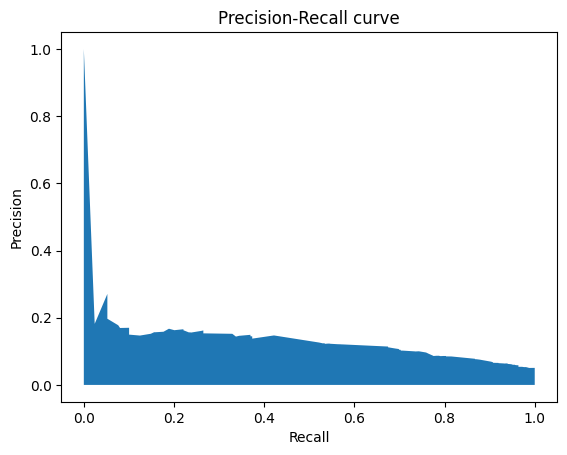

In [59]:
precision, recall, thresholds = precision_recall_curve(y, y_mean)

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve")
plt.show()

In [60]:
y_pred_clf = clf.predict(x)
print(classification_report(y, y_pred_clf))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4735
           1       0.00      0.00      0.00       249

    accuracy                           0.95      4984
   macro avg       0.48      0.50      0.49      4984
weighted avg       0.90      0.95      0.93      4984



## 3.15 - Сохранение

In [61]:
bins_master.to_parquet(filepath['woe_category_map'])
# a.to_excel(binning_data_folder + 'quantitative_binning.xlsx')

In [62]:
bins_master.to_excel(PATHS['directories']['output_folder'] + 'quantitative_binning.xlsx')

Сохранение предсказаний

In [63]:
df_final[['rating_id', 'quantitative_preds']].to_parquet(filepath['predictions'])

Сохранение коэффициентов модели

In [64]:
coef_dict = dict(zip(x.columns, coefs,))
coef_dict['intercept'] = model_intercept

for k, v in coef_dict.items():
    coef_dict[k] = float(v)

CONFIG['model_quantitative']['coeffs'] = coef_dict

Сохранение метрик

In [65]:
CONFIG['model_quantitative']['target_rate'] = {  'actual': round(float(df_final.target.mean()),4)
                                               , 'predicted' :round(float(df_final.quantitative_preds.mean()),4)}
CONFIG['model_quantitative']['gini'] = round(float(gini_mean)*100, 1)


#### Выгрузка

In [66]:
with open('../CONFIGS.yaml', 'w', encoding='utf-8') as file:
    yaml.dump(CONFIG, file)

## 3.16 - Оформление результатов в эксель

In [67]:
df_coeffs = pd.DataFrame([coef_dict]).T.reset_index().set_axis(['Признак', 'Коэфф.'], axis=1)
df_coeffs

,Признак,Коэфф.
0,debt_coverage_woe,-0.888081
1,asset_turnover_ratio_woe,-1.062373
2,debt_ratio_woe,-0.627161
3,quick_ratio_woe,-0.535408
4,revenue_woe,-0.685778
5,current_liabilty_to_assets_woe,-0.549588
6,intercept,-2.868080


In [68]:
CONFIG['calibration_params']['central_tendency']

{'PIT': 0.05273895123991376, 'TTC': 0.05504190055045175}

In [69]:
df_metrics = pd.DataFrame([ {  'Процент дефолта (фактический)': round(float(target_rate_actual*100),2)
                             , 'Процент дефолта (прогнозный)' : round(float(target_rate_predicted*100),2)
                             ,  'Gini': round(float(roc_auc_score(y, y_score=y_pred) * 2 - 1)*100, 2)}]).T\
                             .reset_index()\
                             .set_axis(['Метрика', 'Округ. Значение'], axis=1)
df_metrics

,Метрика,Округ. Значение
0,Процент дефолта (фактический),5.500000
1,Процент дефолта (прогнозный),5.560000
2,Gini,48.920000


In [70]:
df_bins = bins_master.query('feature_name in @best_features').reset_index(drop=True)
df_bins.rename(columns= {  'feature_name': 'Признак'
                , 'category' : 'Категория (1 - хорошо, N - плохо)'
                , 'business_logic' : 'Бизнес-логика'
                , 'woe' : 'Значение WoE'
                , 'boundary_0': 'Нижняя граница диапазона'
                , 'boundary_1': 'Верхняя граница диапазона'
                , 'share_of_bad' : 'Доля дефолтов'
                , 'distribution_of_bad' : 'Распределение дефолтов'
                , 'bads' : 'К-во дефолтов'
                , 'count_obs' :  'К-во наблюдений'
                , 'general_distribution' :'Общее распределение'
                , 'all_old_categories': 'Включает в себя категории'
                }, inplace=True)

In [71]:
df_meaning = business_meaning_df.query('feature in @best_features').rename(columns={'feature': 'Признак', 'business_meaning' : 'Бизнес-смысл', 'business_logic':'Бизнес-логика'})
df_meaning['Бизнес-логика'].replace({'positive':'Прямо-проп.', 'negative' : 'Обратно-проп.'}, inplace=True)

ratios_reversed = {f : k for k, lst in ratios.items() for f in lst}

ratio_categories_translation = {
      'coverage' : 'Coverage / Покрытие'
    , 'efficiency': 'Efficiency / Эффективность'
    , 'leverage': 'Leverage / Долговая нагрузка'
    , 'liquidity': 'Liquidity / Ликвидность'
    , 'profitability': 'Profitability / Прибыльность'
    , 'solvency': 'Solvency / Платежеспособность'
}

df_meaning['Категория'] = (df_meaning['Признак']
                           .apply(lambda x: ratios_reversed[x] if x in ratios_reversed.keys() else '-')
                           .map(ratio_categories_translation)
                           )

In [72]:
test_results

{'spearman':                          Признак 1                       Признак 2  \
 1                debt_coverage_woe        asset_turnover_ratio_woe   
 2                debt_coverage_woe                  debt_ratio_woe   
 3                debt_coverage_woe                 quick_ratio_woe   
 4                debt_coverage_woe                     revenue_woe   
 5                debt_coverage_woe  current_liabilty_to_assets_woe   
 6         asset_turnover_ratio_woe               debt_coverage_woe   
 8         asset_turnover_ratio_woe                  debt_ratio_woe   
 9         asset_turnover_ratio_woe                 quick_ratio_woe   
 10        asset_turnover_ratio_woe                     revenue_woe   
 11        asset_turnover_ratio_woe  current_liabilty_to_assets_woe   
 12                  debt_ratio_woe               debt_coverage_woe   
 13                  debt_ratio_woe        asset_turnover_ratio_woe   
 15                  debt_ratio_woe                 quick_ratio_w

In [73]:
# Инициализируем Excel экспортер
excel = ExcelExporter(filepath=filepath['excel'], overwrite=True)

# Создаем листы для каждого датафрейма
sheet_names = [ 'Бизнес_смысл', 'WoE_Биннинг', 'Коэффициенты', 'Метрики', 'Тесты', 'Данные']
excel.create_spreadsheets(sheet_names)

# Лист с бизнес-смыслом
excel.add_title(
    spreadsheet_name='Бизнес_смысл',
    title='Интерпретация Признаков',
    title_type='h1',
    gap=1
)


excel.add_df(
    spreadsheet_name='Бизнес_смысл',
    df=df_meaning,
    title='Бизнес-смысл и логика признаков',
    title_type='h2',
    gap=2
)


# Лист с WoE биннингом
excel.add_title(
    spreadsheet_name='WoE_Биннинг',
    title='WoE Трансформация и Биннинг',
    title_type='h1',
    gap=1
)

excel.add_df(
    spreadsheet_name='WoE_Биннинг',
    df=df_bins,
    title='Детализация биннинга по лучшим признакам',
    title_type='h2',
    gap=2
)

#  Лист с коэффициентами модели
excel.add_title(
    spreadsheet_name='Коэффициенты',
    title='Коэффициенты модели',
    title_type='h1',
    gap=1
)

excel.add_df(
    spreadsheet_name='Коэффициенты',
    df=df_coeffs,
    title='Значения коэффициентов для лучших признаков',
    title_type='h2',
    gap=2
)

#  Лист с метриками модели
excel.add_title(
    spreadsheet_name='Метрики',
    title='Метрики',
    title_type='h1',
    gap=1
)

excel.add_df(
    spreadsheet_name='Метрики',
    df=df_metrics,
    title='Метрики',
    title_type='h2',
    gap=2
)

#  Лист с тестами 
excel.add_title(
    spreadsheet_name='Тесты',
    title='Тесты',
    title_type='h1',
    gap=1
)

_dfs_tests = list(test_results.values())
_dfs_tests_titles = (pd.Series(test_results.keys())
                     .map({'spearman'     : 'Коэффициент ранговой корреляции Спирмена'
                         , 'cramers'      : 'Коэффициент сопряженности Крамера'
                         , 'vif'          : 'Коэффициент инфляции дисперсии'
                         , 'gini'         : 'Джини признака'
                         , 'monotonicity' : 'Тест на монотонность признака'
                         , 'Wald'         : 'Тест Вальда'})
                     .tolist())

# Добавление всех датафреймов вертикально (друг под другом)
excel.add_dfs(
    spreadsheet_name="Тесты",
    dfs=_dfs_tests,
    titles=_dfs_tests_titles,
    side_by_side=False,  # друг под другом
    vgap=2  # отступ между датафреймами
)

# 4. Лист с выборкой
excel.add_title(
    spreadsheet_name='Данные',
    title='Итоговые Результаты Модели',
    title_type='h1',
    gap=1
)

excel.add_df(
    spreadsheet_name='Данные',
    df=df_final,
    title='Финальные метрики и показатели',
    title_type='h2',
    gap=2
)

excel.save()

print(f"✅ Все датафреймы успешно экспортированы в файл {filepath['excel']}")

Файл '../results/Количественная модель С+ 2025.xlsx' был удален и будет создан заново.
✅ Все датафреймы успешно экспортированы в файл ../results/Количественная модель С+ 2025.xlsx
